In [1]:
import sys 

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from unet import *
from res_unet import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)
print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [2]:
sys.path.append("../")
from dice_loss import *

In [3]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [4]:
image_generator_train = ImageDataGenerator(
    rotation_range=2,
    rescale=1./255,
    shear_range=.02,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=2,
    shear_range=.02,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [5]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train, 
    batch_sz=8
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test
)

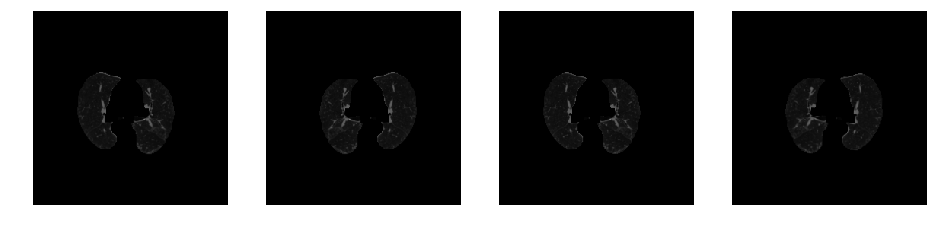

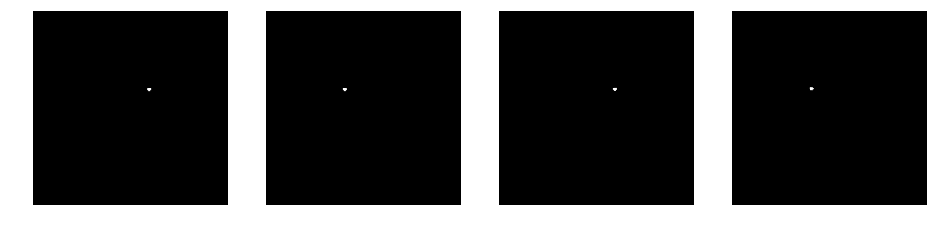

In [6]:
show_augmentation('data/train/image/2.tif', image_generator_train, n_rows=1)
show_augmentation('data/train/label/2.tif', label_generator_train, n_rows=1)

## Instantiate the U-Net

In [7]:
# model = unet()
model = res_unet()
model.compile(
    optimizer = Adam(lr = 3e-5),
    loss=weighted_cross_entropy,
    metrics = [
        'accuracy',
        dice_coef,
        jaccard_distance,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.SpecificityAtSensitivity(.5)
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=0, save_best_only=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
targets is deprecated, use labels instead


In [8]:
# model.summary()

## Train the U-Net

In [9]:
model.fit_generator(
    train_generator,
    steps_per_epoch = 1000,
    epochs = 20,
#     callbacks=[model_checkpoint]
)

Found 475 images belonging to 1 classes.
Found 475 images belonging to 1 classes.
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1000/1000 [==============================] - 217s 217ms/step - loss: 0.0307 - acc: 0.9947 - dice_coef: 0.0374 - jaccard_distance: 74.6532 - precision: 0.0841 - recall: 0.2700 - specificity_at_sensitivity: 0.9707
Epoch 2/20
1000/1000 [==============================] - 206s 206ms/step - loss: 0.0066 - acc: 0.9985 - dice_coef: 0.0926 - jaccard_distance: 52.6295 - precision: 0.7866 - recall: 0.4185 - specificity_at_sensitivity: 0.9997
Epoch 3/20
1000/1000 [==============================] - 206s 206ms/step - loss: 0.0050 - acc: 0.9985 - dice_coef: 0.1349 - jaccard_distance: 44.1226 - precision: 0.8629 - recall: 0.5418 - specificity_at_sensitivity: 0.9999
Epoch 4/20
1000/1000 [==============================] - 206s 206ms/step - loss: 0.0041 - acc: 0.9986 - dice_coef: 0.1721 - jaccard_distance: 38.9416 - prec

In [10]:
model.save('unet_lidc.hdf5') 

In [11]:
model.load_weights('unet_lidc.hdf5')

## Test the U-Net

**Training set test**

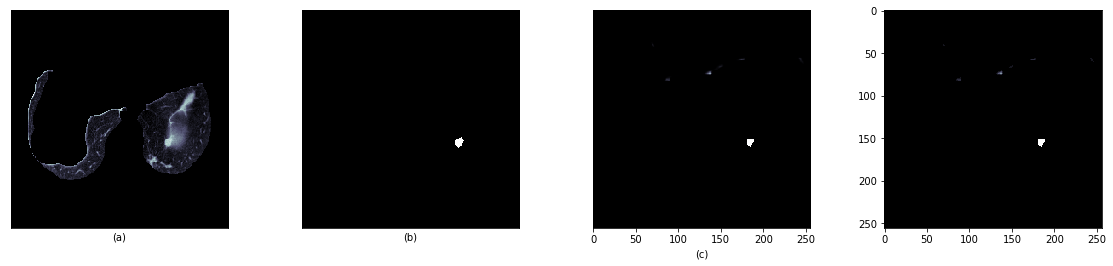

In [46]:
train_idx = np.random.randint(len(os.listdir('data/train/image')))
# train_idx = 449
img0 = io.imread(f'data/train/image/{train_idx}.tif', as_gray=True)
mask0 = io.imread(f'data/train/label/{train_idx}.tif', as_gray=True)
x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), cmap='bone')
axs[3].imshow(np.round(result.reshape(256, 256),1), cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])

plt.show()

**Test set test**

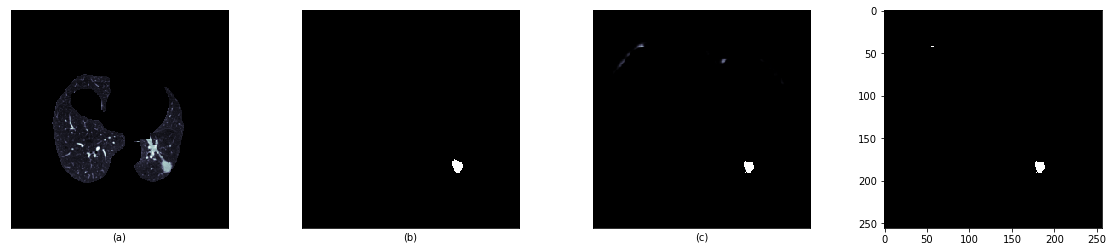

In [26]:
test_idx = np.random.randint(len(os.listdir('data/test/image')))
# test_idx = 53
img0 = io.imread(f'data/test/image/{test_idx}.tif', as_gray=True)
mask0 = io.imread(f'data/test/label/{test_idx}.tif', as_gray=True)

x = img_to_array(img0)
y = img_to_array(mask0)

result = model.predict(x.reshape(1, 256, 256, 1))
# results = model.predict_generator(train_generator, 2, verbose=1)

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
axs[0].imshow(x.reshape(256, 256), cmap='bone')
axs[1].imshow(y.reshape(256, 256), cmap='bone')
axs[2].imshow(result.reshape(256, 256), cmap='bone')
axs[3].imshow(np.round(result.reshape(256, 256),0), cmap='bone')

axs[0].set_xlabel("(a)")
axs[1].set_xlabel("(b)")
axs[2].set_xlabel("(c)")

axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[2].set_xticks([])
axs[2].set_yticks([])

plt.show()